In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from scipy import stats
import datetime as dt
import scipy.interpolate as interpolate
from mySSA import mySSA

In [2]:
volc = np.genfromtxt('nature14565-s6_sigl2015.csv', delimiter=",", dtype=float)
data_jhumar = np.genfromtxt('jhumar_v1.txt', delimiter=",", dtype=float) # ismr reconstruction

In [3]:
yy_jhumar = np.flip(data_jhumar[:,0])
ismr_jhumar = np.flip(data_jhumar[:,1])

yy_jhumar_ann = np.arange( np.trunc(np.min(yy_jhumar))+1 ,np.trunc(np.max(yy_jhumar)))
ismr_jhumar_ann = np.zeros((yy_jhumar_ann.shape[0]))

f = interpolate.interp1d(yy_jhumar, ismr_jhumar, kind='linear')
for i in range(yy_jhumar_ann.shape[0]):
    ismr_jhumar_ann[i] = f(yy_jhumar_ann[i])

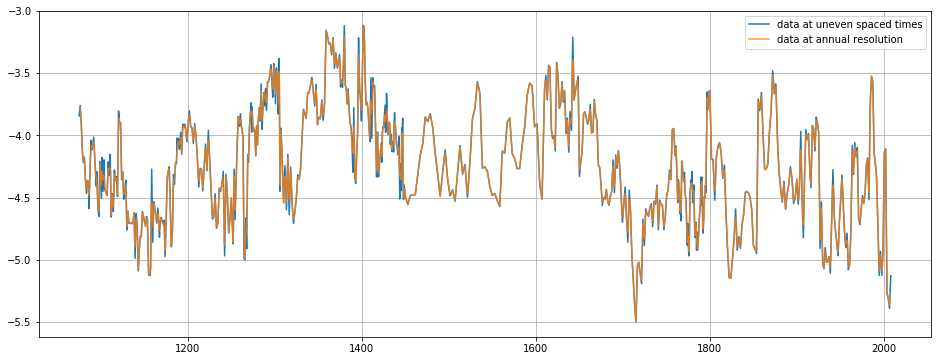

In [4]:
plt.figure(figsize=(16,6))
plt.plot(yy_jhumar, ismr_jhumar, label='data at uneven spaced times')
plt.plot(yy_jhumar_ann, ismr_jhumar_ann, label='data at annual resolution', alpha=0.8)
plt.legend()
plt.grid()

In [5]:
# Singular Spectral Analysis as in Sinha et al 2015
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def ssa(F):
    N = F.shape[0]
    L = 30# The window length. since a 30 year climatology is taken as standard
    K = N - L + 1 # The number of columns in the trajectory matrix.
    # Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
    X = np.column_stack([F[i:i+L] for i in range(0,K)])
    # Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 
    d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
    U, Sigma, V = np.linalg.svd(X)
    V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    n = min(12,d) # In case of noiseless time series with d < 12.
    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
    F_i = np.zeros((n,N))
    for i in range(n):
        F_i[i,:] = X_to_TS(X_elem[i])
    return F_i


In [6]:
ismr_jhumar_ann_ssa = ssa(ismr_jhumar_ann)

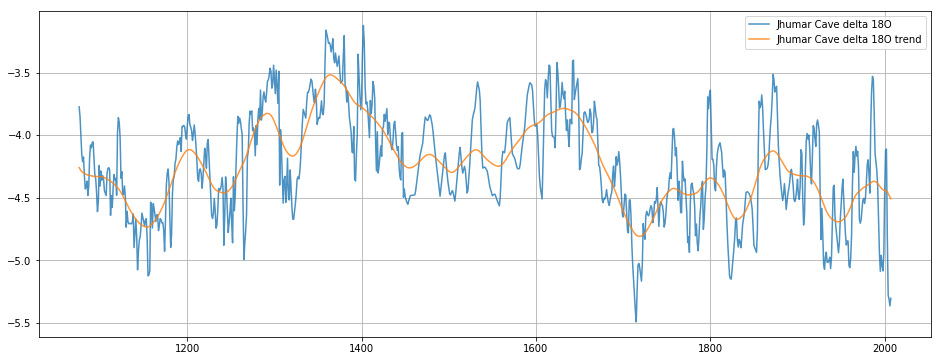

In [7]:
# Trend from Singular Spectral Analysis
plt.figure(figsize=(16,6))
plt.plot(yy_jhumar_ann, ismr_jhumar_ann, label='Jhumar Cave delta 18O', alpha=0.8)
plt.plot(yy_jhumar_ann, ismr_jhumar_ann_ssa[0], label='Jhumar Cave delta 18O trend', alpha=0.8)
plt.legend()
plt.grid()

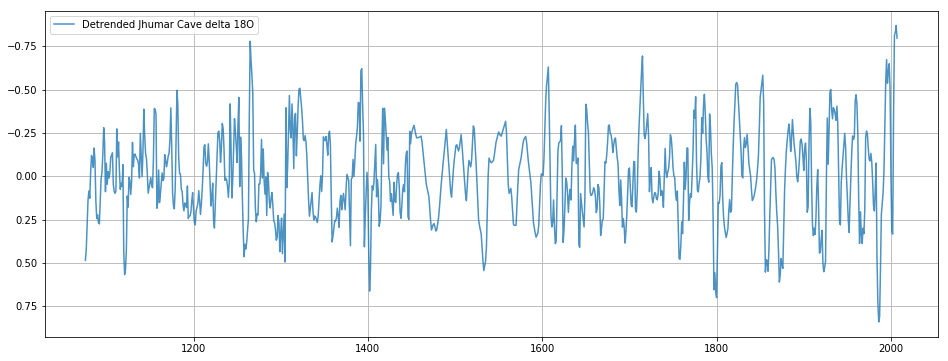

In [8]:
ismr_jhumar_ann_anom = ismr_jhumar_ann - ismr_jhumar_ann_ssa[0]
# DeTrend from Singular Spectral Analysis
plt.figure(figsize=(16,6))
plt.plot(yy_jhumar_ann, ismr_jhumar_ann_anom, label='Detrended Jhumar Cave delta 18O', alpha=0.8)
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

In [9]:
ismr_jhumar_ann_anom_norm = (ismr_jhumar_ann_anom - np.mean(ismr_jhumar_ann_anom)) / (np.std(ismr_jhumar_ann_anom))

In [10]:
event_drought_jhumar = np.zeros((yy_jhumar_ann.shape[0]))
event_yy_volc_all = np.zeros((yy_jhumar_ann.shape[0]))
event_yy_volc_strong = np.zeros((yy_jhumar_ann.shape[0]))
event_yy_volc_all_trop = np.zeros((yy_jhumar_ann.shape[0]))
event_yy_volc_all_nh = np.zeros((yy_jhumar_ann.shape[0]))
event_yy_volc_all_sh = np.zeros((yy_jhumar_ann.shape[0]))
event_yy_volc_strong_trop = np.zeros((yy_jhumar_ann.shape[0]))
event_yy_volc_strong_nh = np.zeros((yy_jhumar_ann.shape[0]))
event_yy_volc_strong_sh = np.zeros((yy_jhumar_ann.shape[0]))

In [11]:
event_drought_jhumar[ismr_jhumar_ann_anom_norm>1.0] = 1.0

for i in range(yy_jhumar_ann.shape[0]):
    #print(event_yy_kobb[i])
    idx = np.asarray(np.where(volc[:,0] == yy_jhumar_ann[i]))
    #print(idx.size)
    if idx.size==0:
        continue
    event_yy_volc_all[i] = 1.0
    if np.abs(volc[idx[0,0],2])>=5.0:
        event_yy_volc_strong[i] = 1.0
    
    if volc[idx[0,0],1] == 1.0:
        event_yy_volc_all_trop[i] = 1.0
    if volc[idx[0,0],1] == 2.0:
        event_yy_volc_all_nh[i] = 1.0
    if volc[idx[0,0],1] == 3.0:
        event_yy_volc_all_sh[i] = 1.0
        
    if (volc[idx[0,0],1] == 1.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_trop[i] = 1.0
    if (volc[idx[0,0],1] == 2.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_nh[i] = 1.0
    if (volc[idx[0,0],1] == 3.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_sh[i] = 1.0

In [12]:
np.savetxt('drought_jhumar_2011.txt', event_drought_jhumar, delimiter=",")
np.savetxt('all_volc_jhumar_2011.txt', event_yy_volc_all, delimiter=",")
np.savetxt('strong_volc_jhumar_2011.txt', event_yy_volc_strong, delimiter=",")
np.savetxt('all_tropical_jhumar_2011.txt', event_yy_volc_all_trop, delimiter=",")
np.savetxt('strong_tropical_jhumar_2011.txt', event_yy_volc_strong_trop, delimiter=",")
np.savetxt('all_nh_jhumar_2011.txt', event_yy_volc_all_nh, delimiter=",")
np.savetxt('strong_nh_jhumar_2011.txt', event_yy_volc_strong_nh, delimiter=",")
np.savetxt('all_sh_jhumar_2011.txt', event_yy_volc_all_sh, delimiter=",")
np.savetxt('strong_sh_jhumar_2011.txt', event_yy_volc_strong_sh, delimiter=",")

In [13]:
print(np.sum(event_yy_volc_all))
print(np.sum(event_yy_volc_strong))
print(np.sum(event_yy_volc_all_trop))
print(np.sum(event_yy_volc_strong_trop))
print(np.sum(event_yy_volc_all_nh))
print(np.sum(event_yy_volc_strong_nh))
print(np.sum(event_yy_volc_all_sh))
print(np.sum(event_yy_volc_strong_sh))

109.0
22.0
34.0
24.0
52.0
3.0
23.0
0.0


In [14]:
# Bootstrap
N = 1000
win = 5
count_elnino_all_volc = np.zeros((N, win))
count_elnino_strong_volc  = np.zeros((N, win))
count_elnino_all_trop  = np.zeros((N, win))
count_elnino_strong_trop  = np.zeros((N, win))
count_elnino_all_nh  = np.zeros((N, win))
count_elnino_strong_nh  = np.zeros((N, win))
count_elnino_all_sh  = np.zeros((N, win))

In [15]:
idx_all = np.asarray(np.where(event_yy_volc_all == 1.0))
idx_strong = np.asarray(np.where(event_yy_volc_strong == 1.0))
idx_all_trop = np.asarray(np.where(event_yy_volc_all_trop == 1.0))
idx_strong_trop = np.asarray(np.where(event_yy_volc_strong_trop == 1.0))
idx_all_nh = np.asarray(np.where(event_yy_volc_all_nh == 1.0))
idx_strong_nh = np.asarray(np.where(event_yy_volc_strong_nh == 1.0))
idx_all_sh = np.asarray(np.where(event_yy_volc_all_sh == 1.0))

In [16]:
print(idx_all[0])

[ 16  32  39  42  51  61  95 104 106 115 124 134 146 154 160 182 186 193
 200 210 230 253 260 265 269 302 305 313 332 338 340 365 372 377 382 387
 394 401 402 404 426 429 436 452 461 465 478 491 500 509 514 519 525 543
 545 561 565 570 578 586 591 597 617 619 632 643 644 645 649 653 663 680
 686 690 694 707 710 720 721 733 739 745 747 756 760 770 777 780 786 797
 799 808 811 814 827 832 836 843 849 850 855 867 871 881 888 892 903 906
 915]


In [17]:
ismr_jhumar_ann_anom_norm = -ismr_jhumar_ann_anom_norm
niter = 0
while niter<N:
    rand_year_all = random.sample(list(idx_all[0]), 1)
    if (rand_year_all[0]<ismr_jhumar_ann_anom_norm.shape[0]-win):
        count_elnino_all_volc[niter,:] = ismr_jhumar_ann_anom_norm[rand_year_all[0]:rand_year_all[0]+win]
    
    rand_year_strong = random.sample(list(idx_strong[0]), 1)
    if (rand_year_strong[0]<ismr_jhumar_ann_anom_norm.shape[0]-win):
        count_elnino_strong_volc[niter,:] = ismr_jhumar_ann_anom_norm[rand_year_strong[0]:rand_year_strong[0]+win]
    
    rand_year_all_trop = random.sample(list(idx_all_trop[0]), 1)
    if (rand_year_all_trop[0]<ismr_jhumar_ann_anom_norm.shape[0]-win):
        count_elnino_all_trop[niter,:] = ismr_jhumar_ann_anom_norm[rand_year_all_trop[0]:rand_year_all_trop[0]+win]

    rand_year_strong_trop = random.sample(list(idx_strong_trop[0]), 1)
    if (rand_year_strong_trop[0]<ismr_jhumar_ann_anom_norm.shape[0]-win):
        count_elnino_strong_trop[niter,:] = ismr_jhumar_ann_anom_norm[rand_year_strong_trop[0]:rand_year_strong_trop[0]+win]

    rand_year_all_nh = random.sample(list(idx_all_nh[0]), 1)
    if (rand_year_all_nh[0]<ismr_jhumar_ann_anom_norm.shape[0]-win):
        count_elnino_all_nh[niter,:] = ismr_jhumar_ann_anom_norm[rand_year_all_nh[0]:rand_year_all_nh[0]+win]

    rand_year_strong_nh = random.sample(list(idx_strong_nh[0]), 1)
    if (rand_year_strong_nh[0]<ismr_jhumar_ann_anom_norm.shape[0]-win):
        count_elnino_strong_nh[niter,:] = ismr_jhumar_ann_anom_norm[rand_year_strong_nh[0]:rand_year_strong_nh[0]+win]

    rand_year_all_sh = random.sample(list(idx_all_sh[0]), 1)
    if (rand_year_all_sh[0]<ismr_jhumar_ann_anom_norm.shape[0]-win):
        count_elnino_all_sh[niter,:] = ismr_jhumar_ann_anom_norm[rand_year_all_sh[0]:rand_year_all_sh[0]+win]
    
    #print(s[rand_year_all[0]:rand_year_all[0]+win])
    #print(rand_year_all[0])
    niter = niter + 1 

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


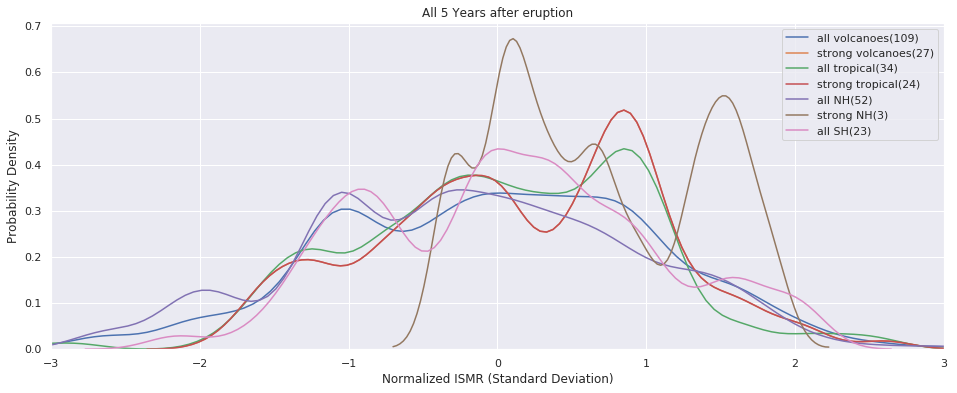

In [18]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc.flatten(), label='all volcanoes(109)')
sns.kdeplot(count_elnino_strong_volc.flatten(), label='strong volcanoes(27)')
sns.kdeplot(count_elnino_all_trop.flatten(), label='all tropical(34)')
sns.kdeplot(count_elnino_strong_volc.flatten(), label='strong tropical(24)')
sns.kdeplot(count_elnino_all_nh.flatten(), label='all NH(52)')
sns.kdeplot(count_elnino_strong_nh.flatten(), label='strong NH(3)')
sns.kdeplot(count_elnino_all_sh.flatten(), label='all SH(23)')
plt.title('All 5 Years after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


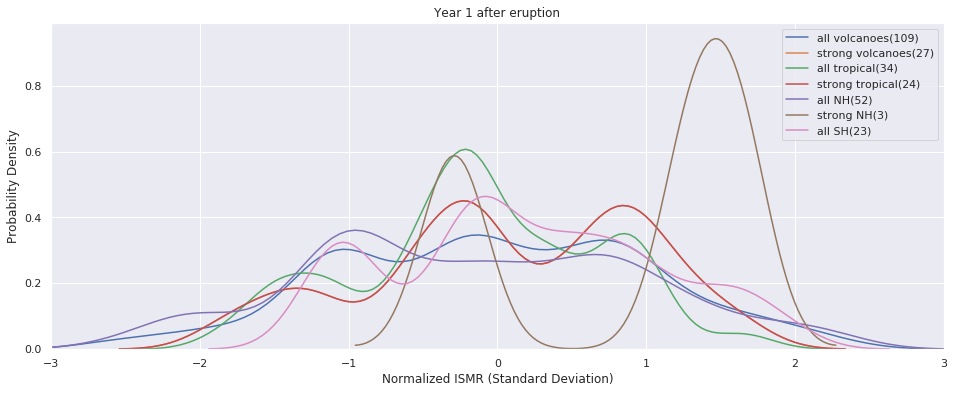

In [19]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,0], label='all volcanoes(109)')
sns.kdeplot(count_elnino_strong_volc[:,0], label='strong volcanoes(27)')
sns.kdeplot(count_elnino_all_trop[:,0], label='all tropical(34)')
sns.kdeplot(count_elnino_strong_volc[:,0], label='strong tropical(24)')
sns.kdeplot(count_elnino_all_nh[:,0], label='all NH(52)')
sns.kdeplot(count_elnino_strong_nh[:,0], label='strong NH(3)')
sns.kdeplot(count_elnino_all_sh[:,0], label='all SH(23)')
plt.title('Year 1 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


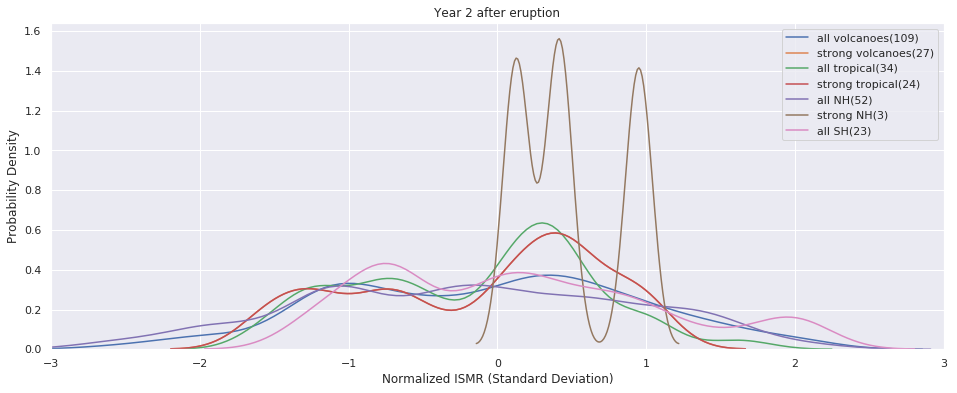

In [20]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,1], label='all volcanoes(109)')
sns.kdeplot(count_elnino_strong_volc[:,1], label='strong volcanoes(27)')
sns.kdeplot(count_elnino_all_trop[:,1], label='all tropical(34)')
sns.kdeplot(count_elnino_strong_volc[:,1], label='strong tropical(24)')
sns.kdeplot(count_elnino_all_nh[:,1], label='all NH(52)')
sns.kdeplot(count_elnino_strong_nh[:,1], label='strong NH(3)')
sns.kdeplot(count_elnino_all_sh[:,1], label='all SH(23)')
plt.title('Year 2 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


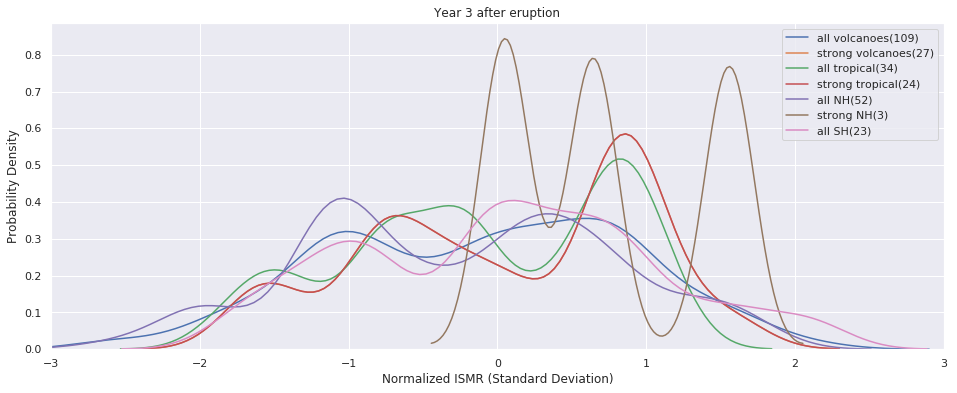

In [21]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,2], label='all volcanoes(109)')
sns.kdeplot(count_elnino_strong_volc[:,2], label='strong volcanoes(27)')
sns.kdeplot(count_elnino_all_trop[:,2], label='all tropical(34)')
sns.kdeplot(count_elnino_strong_volc[:,2], label='strong tropical(24)')
sns.kdeplot(count_elnino_all_nh[:,2], label='all NH(52)')
sns.kdeplot(count_elnino_strong_nh[:,2], label='strong NH(3)')
sns.kdeplot(count_elnino_all_sh[:,2], label='all SH(23)')
plt.title('Year 3 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


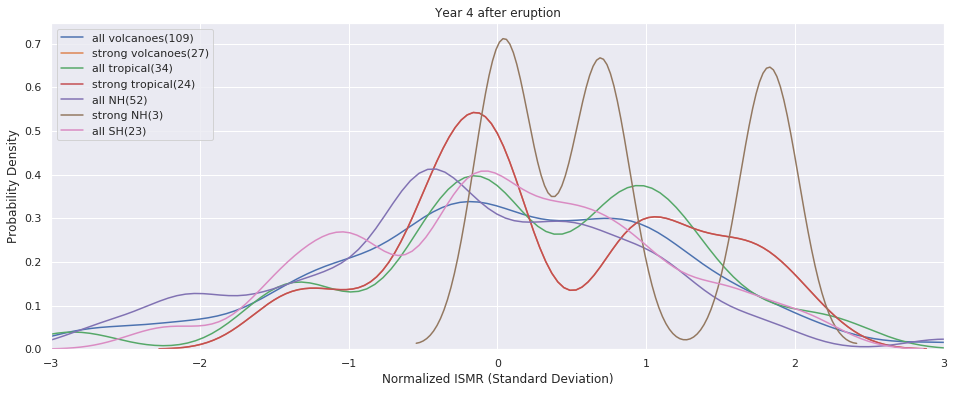

In [22]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,3], label='all volcanoes(109)')
sns.kdeplot(count_elnino_strong_volc[:,3], label='strong volcanoes(27)')
sns.kdeplot(count_elnino_all_trop[:,3], label='all tropical(34)')
sns.kdeplot(count_elnino_strong_volc[:,3], label='strong tropical(24)')
sns.kdeplot(count_elnino_all_nh[:,3], label='all NH(52)')
sns.kdeplot(count_elnino_strong_nh[:,3], label='strong NH(3)')
sns.kdeplot(count_elnino_all_sh[:,3], label='all SH(23)')
plt.title('Year 4 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


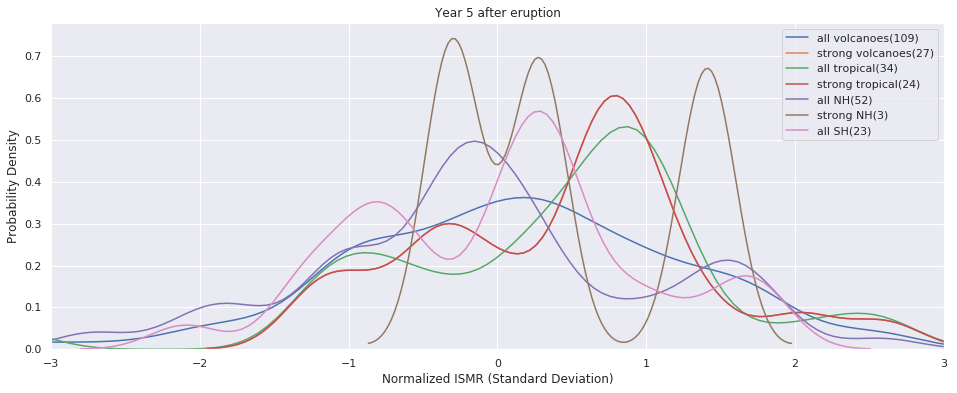

In [23]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,4], label='all volcanoes(109)')
sns.kdeplot(count_elnino_strong_volc[:,4], label='strong volcanoes(27)')
sns.kdeplot(count_elnino_all_trop[:,4], label='all tropical(34)')
sns.kdeplot(count_elnino_strong_volc[:,4], label='strong tropical(24)')
sns.kdeplot(count_elnino_all_nh[:,4], label='all NH(52)')
sns.kdeplot(count_elnino_strong_nh[:,4], label='strong NH(3)')
sns.kdeplot(count_elnino_all_sh[:,4], label='all SH(23)')
plt.title('Year 5 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

In [24]:
ismr_jhumar_ann_yy = np.zeros((ismr_jhumar_ann_anom_norm.shape[0],3))
ismr_jhumar_ann_yy[:,0] = yy_jhumar_ann[:]
ismr_jhumar_ann_yy[:,1] = event_yy_volc_strong[:]
ismr_jhumar_ann_yy[:,2] = -ismr_jhumar_ann_anom_norm[:]
np.savetxt('ismr_jhumar_ann_yy.txt', ismr_jhumar_ann_yy, delimiter=",")